In [1]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available


✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [2]:
# Fix NumPy version conflict cho SHAP
# SHAP requires NumPy <= 2.1, nhưng bạn đang dùng NumPy 2.2

!pip install "numpy<2.0" --upgrade
!pip install shap

print("\n" + "="*80)
print("⚠ QUAN TRỌNG: Sau khi cài đặt xong, bạn PHẢI RESTART KERNEL!")
print("   Cách restart: Kernel menu -> Restart Kernel")
print("   Sau đó chạy lại tất cả các cell từ đầu")
print("="*80)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


⚠ QUAN TRỌNG: Sau khi cài đặt xong, bạn PHẢI RESTART KERNEL!
   Cách restart: Kernel menu -> Restart Kernel
   Sau đó chạy lại tất cả các cell từ đầu




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path}")
else:
    print(f"✗ Model not found: {model_path}")

# 1.2. Load dữ liệu ACB
provider = VNStockDataProvider()
print("\nĐang lấy dữ liệu ACB từ vnstock...")
df_raw = provider.get_ohlcv_data('ACB', '2021-12-14', '2023-12-31')
print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# 1.3. Xử lý dữ liệu và thêm technical indicators
df_processed = df_raw.copy()
df_processed.rename(columns={'date': 'time'}, inplace=True)
df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2022')
print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_acb.pth

Đang lấy dữ liệu ACB từ vnstock...
LẤY DỮ LIỆU OHLCV TỪ VNSTOCK
📋 Danh sách mã: ['ACB']
📅 Khoảng thời gian: 2021-12-14 đến 2023-12-31
⏱️  Phiên: 1D
📡 Nguồn: VCI
--------------------------------------------------------------------------------
📡 Đang lấy dữ liệu cho ACB...
✅ ACB: 536 dòng

KẾT QUẢ
✅ Tổng số dòng dữ liệu: 536
✅ Số mã thành công: 1

📋 Các cột dữ liệu:
   • date
   • open
   • high
   • low
   • close
   • volume
   • symbol

📊 Thống kê:
   • Số mã: 1
   • Khoảng thời gian: 2021-11-10 đến 2023-12-29

📄 Mẫu dữ liệu (10 dòng đầu):
         date   open   high    low  close   volume symbol
0  2021/11/10  15.71  15.73  15.55  15.66  4367400    ACB
1  2021/11/11  15.62  15.73  15.24  15.48  7129400    ACB
2  2021/11/12  15.48  15.64  15.31  15.64  4376100    ACB
3  2021/11/15  15.66  15.76  15.59  15.66  4878900    ACB
4  2021/11/16  15.64  15.66  15.38  15.55  5211500    ACB
5  2021/11/17  15.55  15.71  15.38  1

In [4]:
states

[[16.13,
  1000,
  0,
  0.058832443283398206,
  62.73727349951207,
  201.75122945903712,
  13.763755845866813],
 [15.8,
  983.85387,
  1.0,
  0.05685631365899191,
  53.05424712211454,
  91.60756501182094,
  13.202346476723822],
 [15.83,
  904.7748700000001,
  6.0,
  0.05705329114802815,
  53.753059326264605,
  40.34157832744377,
  12.69657802248274],
 [15.62,
  873.0832100000001,
  8.0,
  0.039805301532339854,
  48.32978290947432,
  20.820357683067417,
  12.226935886401735],
 [15.48,
  841.8119700000001,
  10.0,
  0.01467020651683093,
  45.06544126406424,
  -43.50585655761322,
  12.32246374026318],
 [15.36,
  810.82101,
  12.0,
  -0.014762363156480163,
  42.420623790439784,
  -80.24278872925727,
  12.73439469469545],
 [15.52,
  780.07029,
  14.0,
  -0.024890303918688517,
  46.89574514584752,
  -41.84373978424329,
  12.227398648482746],
 [15.64,
  748.9992500000001,
  16.0,
  -0.02296900048259687,
  50.0324378202315,
  34.69797947741471,
  12.008622604688904],
 [15.5,
  717.687970000000

In [5]:
actions

[1,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 3,
 3,
 5,
 3,
 3,
 3,
 3,
 -1,
 5,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 5,
 -5,
 -1,
 -1,
 2,
 -5,
 2,
 2,
 2,
 -5,
 2,
 2,
 -5,
 2,
 2,
 -1,
 -1,
 -1,
 2,
 5,
 -1,
 -1,
 -1,
 -5,
 2,
 2,
 5,
 -3,
 -3,
 5,
 5,
 -3,
 -3,
 -1,
 -1,
 -3,
 3,
 -1,
 -5,
 2,
 2,
 -1,
 2,
 2,
 -5,
 2,
 -1,
 3,
 -1,
 -1,
 2,
 2,
 -1,
 -5,
 2,
 2,
 2,
 -5,
 2,
 -1,
 -1,
 -1,
 5,
 5,
 -1,
 -1,
 -1,
 -1,
 -1,
 3,
 -1,
 5,
 -3,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 2,
 -5,
 2,
 -1,
 -1,
 3,
 -1,
 5,
 -1,
 -1,
 -1,
 5,
 -1,
 5,
 -3,
 -1,
 -1,
 -1,
 5,
 -1,
 -1,
 -1,
 -5,
 5,
 -3,
 -3,
 5,
 -1,
 -1,
 -3,
 -3,
 -3,
 -3,
 3,
 3,
 3,
 3,
 -1,
 3,
 -1,
 5,
 -3,
 -1,
 -1,
 -1,
 5,
 -5,
 -5,
 5,
 5,
 -1,
 -5,
 -5,
 2,
 2,
 -5,
 2,
 2,
 -5,
 2,
 2,
 2,
 2,
 -5,
 2,
 2,
 -5,
 2,
 2,
 2,
 -5,
 2,
 2,
 -1,
 2,
 2,
 -5,
 2,
 -5,
 2,
 2,
 2,
 -1,
 4,
 4,
 -1,
 -1,
 -1,
 4,
 -5,
 -1,
 4,
 -1,
 -3,
 -1,
 -1,
 3,
 -1,
 -1,
 -1,
 5,
 -1,
 -5,
 -1,
 -1,
 2,
 2,
 5,
 -1,
 -1,
 -1,


In [6]:
def calculate_reward_components(states, actions, prices):
    """
    Tính 4 thành phần reward ở ĐƠN VỊ THÔ (tiền tệ) theo đúng quy ước RL:
    r_t sinh ra khi đi từ (s_t, a_t) -> s_{t+1}.

    Yêu cầu sửa: đúng thứ tự trừ theo công thức, bỏ hoàn toàn phần CHIA (tính %).

    Đầu vào:
      - states: list/array các trạng thái (s_0..s_T), mỗi state: [price, balance, shares, ...]
      - actions: list/array hành động (a_0..a_{T-1})
      - prices:  list/np.array giá đóng cửa (P_0..P_T)

    Đầu ra:
      - R_profit, R_risk, R_position, R_stability: mỗi mảng độ dài T (đơn vị tiền)
    """
    # Số bước hợp lệ (tránh lệch chiều dài)
    n = min(len(states) - 1, len(actions), len(prices) - 1)

    # 1) Khởi tạo
    R_profit = np.zeros(n)
    R_risk = np.zeros(n)
    R_position = np.zeros(n)
    R_stability = np.zeros(n)

    # 2) Chỉ số phụ trợ
    MA10 = np.convolve(np.asarray(prices), np.ones(10) / 10, mode='same')  # cho R_position (không chia %)
    running_max_price = -np.inf  # cho R_risk: max(P_0..P_t)

    # 3) Vòng lặp cho từng bước t
    for t in range(n):
        P_t = float(prices[t])
        P_next = float(prices[t + 1])

        # Cập nhật đỉnh giá lịch sử (running max) dùng đúng thứ tự
        if P_t > running_max_price:
            running_max_price = P_t

        # Hành động tại t -> quy về dấu: 1 (mua), -1 (bán), 0 (giữ)
        a_t = actions[t]
        try:
            a_t_val = float(a_t)
        except Exception:
            a_t_val = a_t
        action_sign = 1 if a_t_val > 0 else (-1 if a_t_val < 0 else 0)

        # Trích xuất số cổ phiếu đang nắm giữ tại t
        h_t = float(states[t][2])

        # ---------------------------------------------------------------
        # 1) R_profit (ĐƠN VỊ THÔ): (P_{t+1} - P_t) * h_t
        #    (BỎ chia theo %; dùng đúng thứ tự P_{t+1} - P_t)
        # ---------------------------------------------------------------
        R_profit[t] = (P_next - P_t) * h_t

        # ---------------------------------------------------------------
        # 2) R_risk (ĐƠN VỊ THÔ): -| (running_max_price - P_t) | * |h_t|
        #    (BỎ chia theo %; chú ý THỨ TỰ TRỪ là peak - current)
        # ---------------------------------------------------------------
        drawdown_raw = running_max_price - P_t  # đúng thứ tự: đỉnh - hiện tại
        R_risk[t] = -abs(drawdown_raw) * abs(h_t)

        # ---------------------------------------------------------------
        # 3) R_position (ĐƠN VỊ THÔ): so sánh sign(P_t - MA10_t) với sign(a_t)
        #    Nếu cùng dấu: + (P_t * |h_t|); ngược dấu: - (P_t * |h_t|); nếu a_t=0 -> 0
        #    (BỎ chia %, chỉ dùng mức giá làm thang đo theo vị thế)
        # ---------------------------------------------------------------
        trend_val = P_t - MA10[t]
        sign_trend = 1 if trend_val > 0 else (-1 if trend_val < 0 else 0)
        scale_pos = P_t * abs(h_t)
        if action_sign == 0 or scale_pos == 0:
            R_position[t] = 0.0
        elif sign_trend == action_sign:
            R_position[t] = +scale_pos
        else:
            R_position[t] = -scale_pos

        # ---------------------------------------------------------------
        # 4) R_stability (ĐƠN VỊ THÔ): -| P_{t+1} - P_t | * |h_t|
        #    (BỎ chia %, dùng đúng thứ tự chênh lệch giá trong bước t)
        # ---------------------------------------------------------------
        R_stability[t] = -abs(P_next - P_t) * abs(h_t)

    return R_profit, R_risk, R_position, R_stability

# Tính toán 4 components theo (s_t, a_t) -> r_t (đơn vị thô)
prices = df_processed['close'].values
R_profit, R_risk, R_position, R_stability = calculate_reward_components(states, actions, prices)

# Chuyển rewards từ môi trường (nếu có)
R_original = np.array(rewards)

print("✓ Đã tính toán 4 reward components (ĐƠN VỊ THÔ, không chia %):")
print(f"  R_profit: mean={R_profit.mean():.4f}, std={R_profit.std():.4f}")
print(f"  R_risk: mean={R_risk.mean():.4f}, std={R_risk.std():.4f}")
print(f"  R_position: mean={R_position.mean():.4f}, std={R_position.std():.4f}")
print(f"  R_stability: mean={R_stability.mean():.4f}, std={R_stability.std():.4f}")
print(f"  R_original: mean={R_original.mean():.4f}, std={R_original.std():.4f}")

✓ Đã tính toán 4 reward components (ĐƠN VỊ THÔ, không chia %):
  R_profit: mean=0.0056, std=13.2682
  R_risk: mean=-115.6918, std=64.0168
  R_position: mean=-59.1848, std=777.4744
  R_stability: mean=-9.1910, std=9.5692
  R_original: mean=0.0674, std=13.2873


In [7]:
R_risk

array([-0.0000e+00, -3.3000e-01, -1.8000e+00, -4.0800e+00, -6.5000e+00,
       -9.2400e+00, -8.5400e+00, -7.8400e+00, -1.1340e+01, -1.5400e+01,
       -1.6500e+01, -1.5600e+01, -1.7680e+01, -1.2320e+01, -6.0000e-01,
       -0.0000e+00, -0.0000e+00, -9.1000e+00, -1.6340e+01, -1.5480e+01,
       -0.0000e+00, -3.4300e+00, -5.2000e+00, -1.6500e+00, -4.4280e+01,
       -3.4810e+01, -4.2340e+01, -3.8760e+01, -4.9840e+01, -3.5200e+01,
       -2.7000e+01, -2.8620e+01, -3.5380e+01, -3.4980e+01, -4.5240e+01,
       -4.5390e+01, -7.1020e+01, -5.1840e+01, -3.4000e+01, -6.1360e+01,
       -7.9920e+01, -7.0070e+01, -6.8340e+01, -7.5790e+01, -6.8640e+01,
       -6.9500e+01, -7.2280e+01, -7.0890e+01, -6.9500e+01, -6.4680e+01,
       -5.8650e+01, -6.7200e+01, -7.3700e+01, -7.7220e+01, -8.4800e+01,
       -7.6800e+01, -7.4000e+01, -6.6040e+01, -6.3270e+01, -5.7240e+01,
       -6.5790e+01, -6.7200e+01, -6.1610e+01, -5.1620e+01, -5.9400e+01,
       -5.3460e+01, -4.8760e+01, -5.2000e+01, -7.3670e+01, -1.00

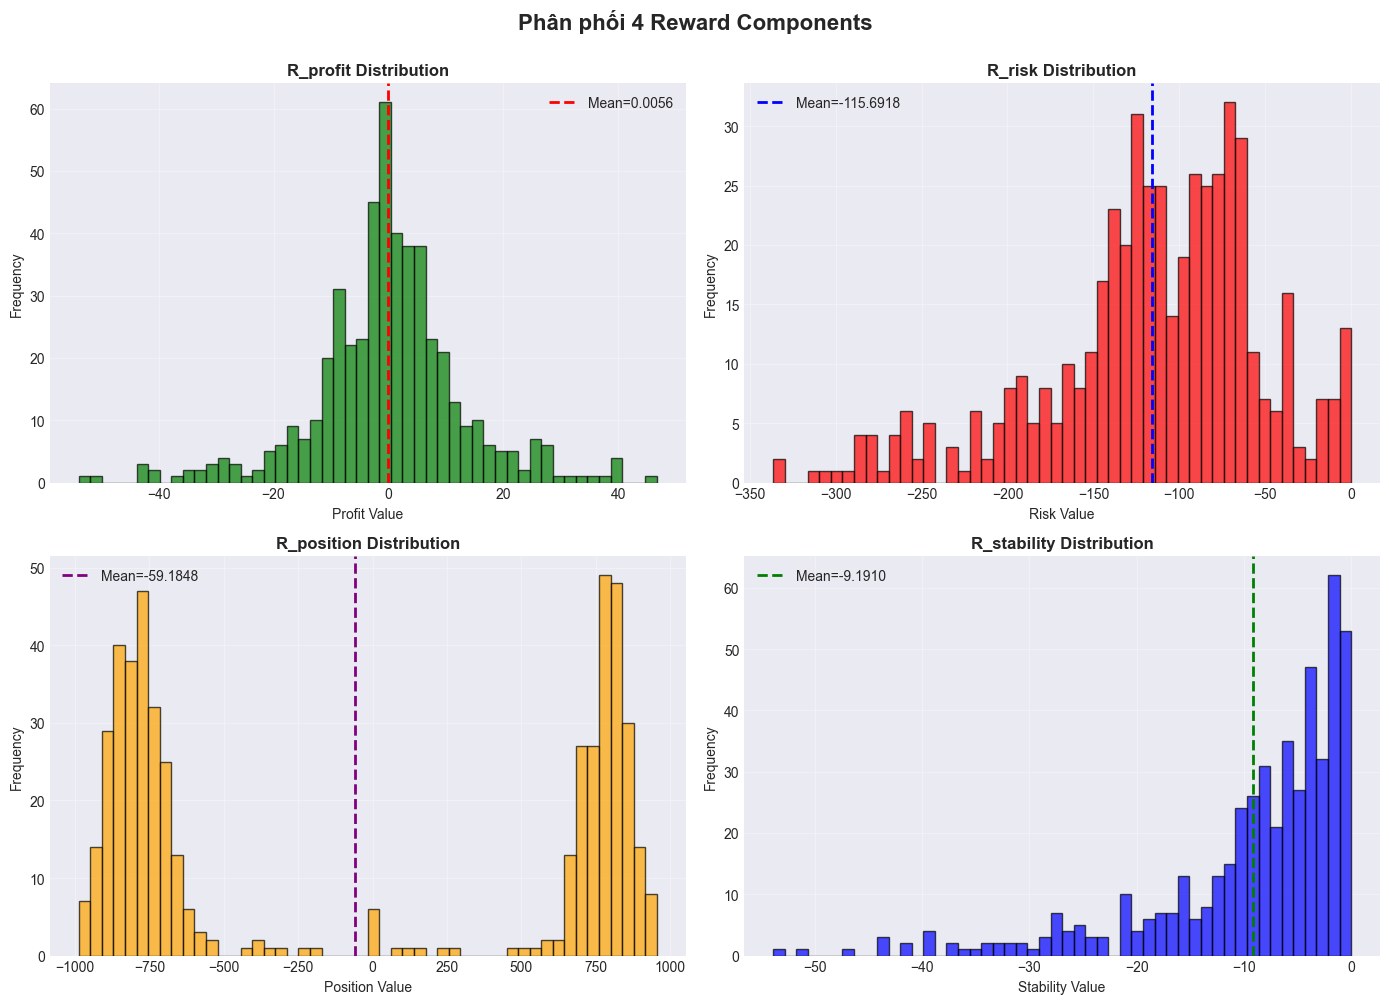

In [8]:
# Histogram phân phối của 4 components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].hist(R_profit, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,0].set_title('R_profit Distribution', fontweight='bold')
axes[0,0].set_xlabel('Profit Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(R_profit.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={R_profit.mean():.4f}')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(R_risk, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,1].set_title('R_risk Distribution', fontweight='bold')
axes[0,1].set_xlabel('Risk Value')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(R_risk.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean={R_risk.mean():.4f}')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].hist(R_position, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('R_position Distribution', fontweight='bold')
axes[1,0].set_xlabel('Position Value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(R_position.mean(), color='purple', linestyle='--', linewidth=2, label=f'Mean={R_position.mean():.4f}')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].hist(R_stability, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1,1].set_title('R_stability Distribution', fontweight='bold')
axes[1,1].set_xlabel('Stability Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(R_stability.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={R_stability.mean():.4f}')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Phân phối 4 Reward Components', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [9]:
# ============================================================================
# PHẦN 1: RDX - ĐỊNH NGHĨA WEIGHTS TỪ DOMAIN KNOWLEDGE
# ============================================================================

# Weights được định nghĩa TRƯỚC dựa trên domain knowledge trading
# KHÔNG dùng gradient hay machine learning để tính weights!

print("="*80)
print("PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION")
print("="*80)

# Domain knowledge weights cho trading strategy
w_rdx = np.array([
    0.98,  
    0.01,  
    0.005,  
    0.005   
])

print("\n✓ RDX Weights (Domain Knowledge):")
print(f"  w1 (R_profit):    {w_rdx[0]:.2f} - Profit maximization")
print(f"  w2 (R_risk):      {w_rdx[1]:.5f} - Risk management")
print(f"  w3 (R_position):  {w_rdx[2]:.5f} - Position sizing")
print(f"  w4 (R_stability): {w_rdx[3]:.5f} - Portfolio stability")
print(f"  Tổng: {w_rdx.sum():.2f}")

PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION

✓ RDX Weights (Domain Knowledge):
  w1 (R_profit):    0.98 - Profit maximization
  w2 (R_risk):      0.01000 - Risk management
  w3 (R_position):  0.00500 - Position sizing
  w4 (R_stability): 0.00500 - Portfolio stability
  Tổng: 1.00


In [10]:
# Tái tạo reward từ 4 components với RDX weights
R_components = np.column_stack([R_profit, R_risk, R_position, R_stability])
R_reconstructed = R_components @ w_rdx

# Tính metrics để validate RDX
mse = mean_squared_error(R_original, R_reconstructed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(R_original, R_reconstructed)
r2 = r2_score(R_original, R_reconstructed)
correlation = np.corrcoef(R_original, R_reconstructed)[0, 1]

print("✓ RDX Reconstruction Metrics:")
print(f"  MSE:         {mse:.6f}")
print(f"  RMSE:        {rmse:.6f}")
print(f"  MAE:         {mae:.6f}")
print(f"  R² Score:    {r2:.4f} {'✓ Good' if r2 > 0.7 else '✗ Poor'}")
print(f"  Correlation: {correlation:.4f} {'✓ Strong' if abs(correlation) > 0.8 else '~ Moderate' if abs(correlation) > 0.5 else '✗ Weak'}")

# # Phân tích reward theo action type
# print("\n✓ Reward Analysis by Action Type:")
# for action_type, condition in [('BUY', np.array(actions) > 0), 
#                                 ('SELL', np.array(actions) < 0), 
#                                 ('HOLD', np.array(actions) == 0)]:
#     if np.any(condition):
#         avg_original = R_original[condition].mean()
#         avg_reconstructed = R_reconstructed[condition].mean()
#         error = abs(avg_original - avg_reconstructed)
#         count = condition.sum()
#         print(f"  {action_type:4s}: R_orig={avg_original:7.4f}, R_recon={avg_reconstructed:7.4f}, err={error:.4f}, n={count}")

# Phân tích đóng góp từng component
print("\n✓ Average Contribution by Component:")
contrib_profit_avg = (w_rdx[0] * R_profit).mean()
contrib_risk_avg = (w_rdx[1] * R_risk).mean()
contrib_position_avg = (w_rdx[2] * R_position).mean()
contrib_stability_avg = (w_rdx[3] * R_stability).mean()

print(f"  Profit contribution:    {contrib_profit_avg:+.4f} ({contrib_profit_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Risk contribution:      {contrib_risk_avg:+.4f} ({contrib_risk_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Position contribution:  {contrib_position_avg:+.4f} ({contrib_position_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Stability contribution: {contrib_stability_avg:+.4f} ({contrib_stability_avg/R_reconstructed.mean()*100:+.1f}%)")

✓ RDX Reconstruction Metrics:
  MSE:         19.038436
  RMSE:        4.363306
  MAE:         4.039194
  R² Score:    0.8922 ✓ Good
  Correlation: 0.9571 ✓ Strong

✓ Average Contribution by Component:
  Profit contribution:    +0.0055 (-0.4%)
  Risk contribution:      -1.1569 (+77.5%)
  Position contribution:  -0.2959 (+19.8%)
  Stability contribution: -0.0460 (+3.1%)


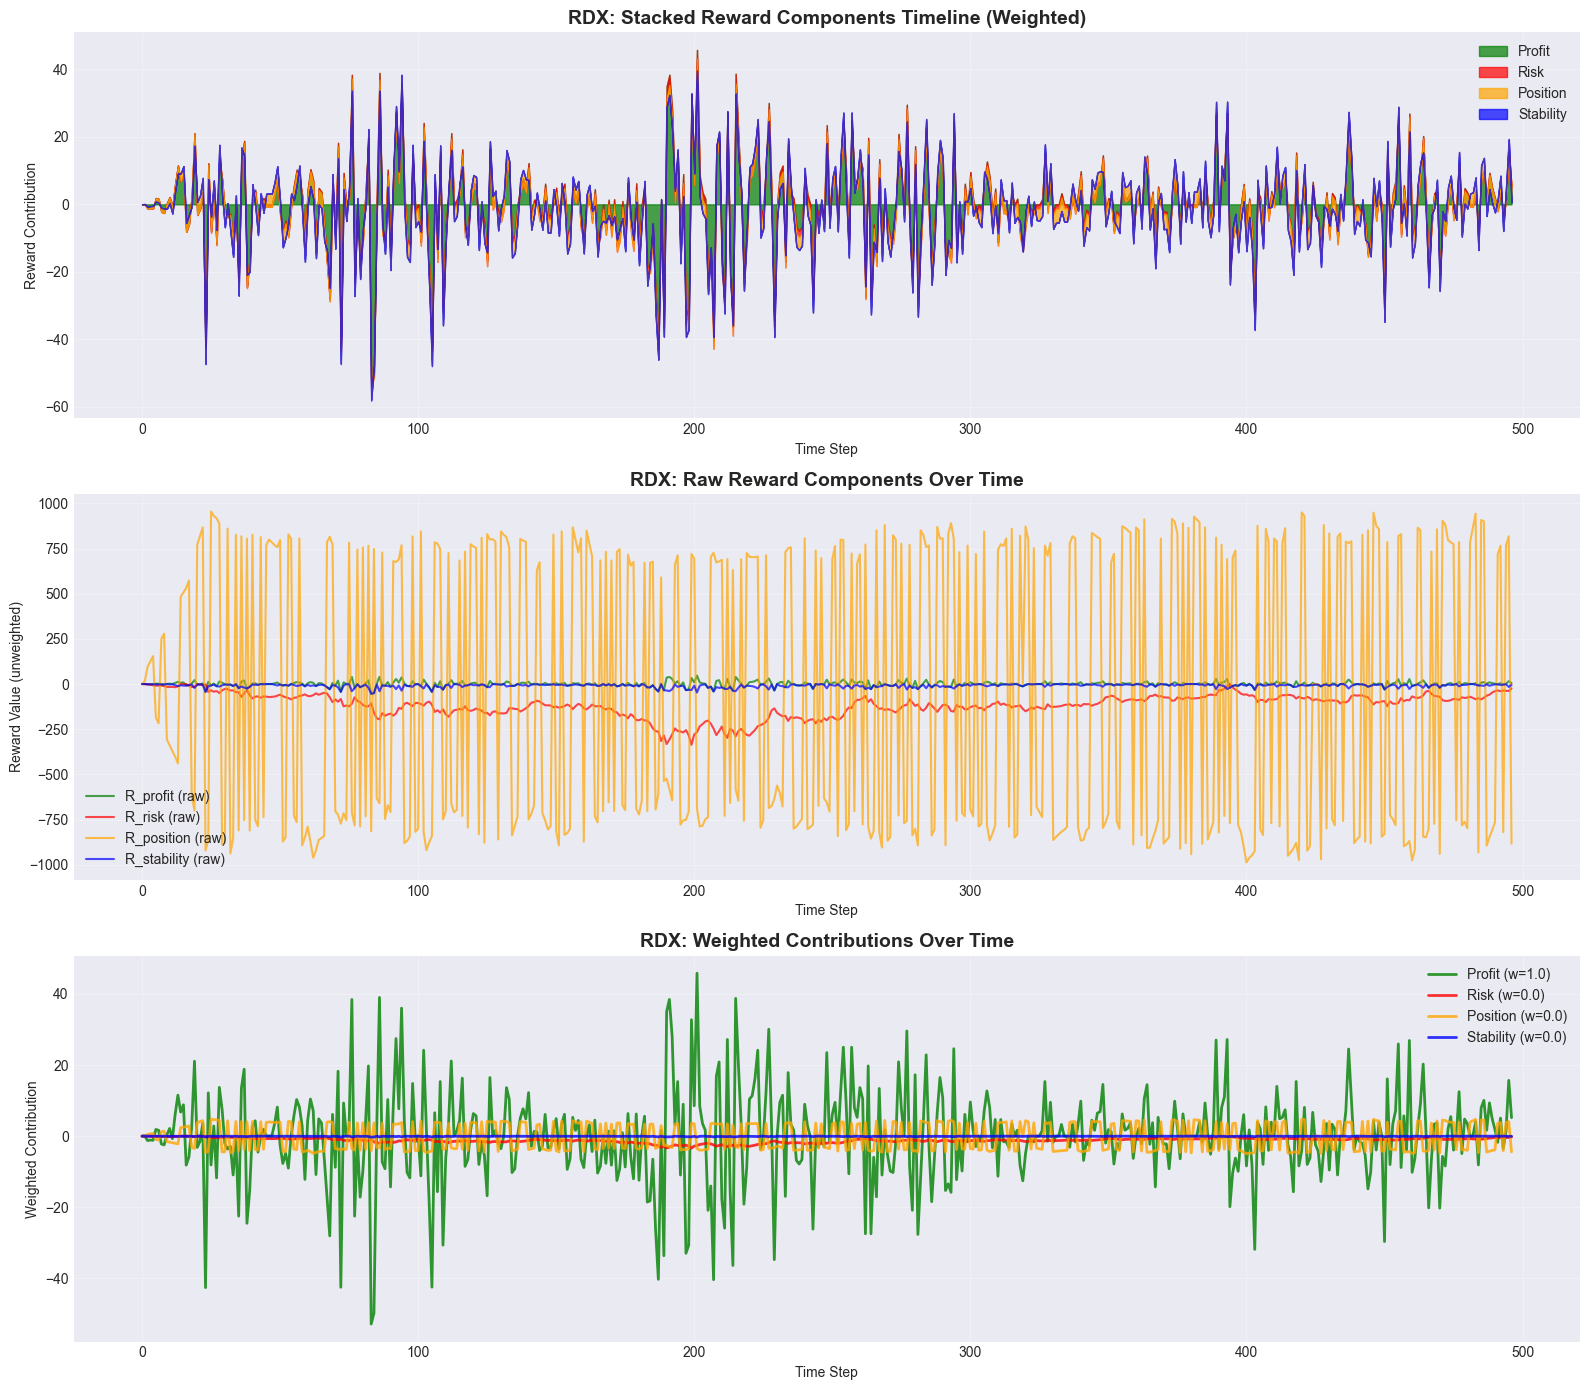

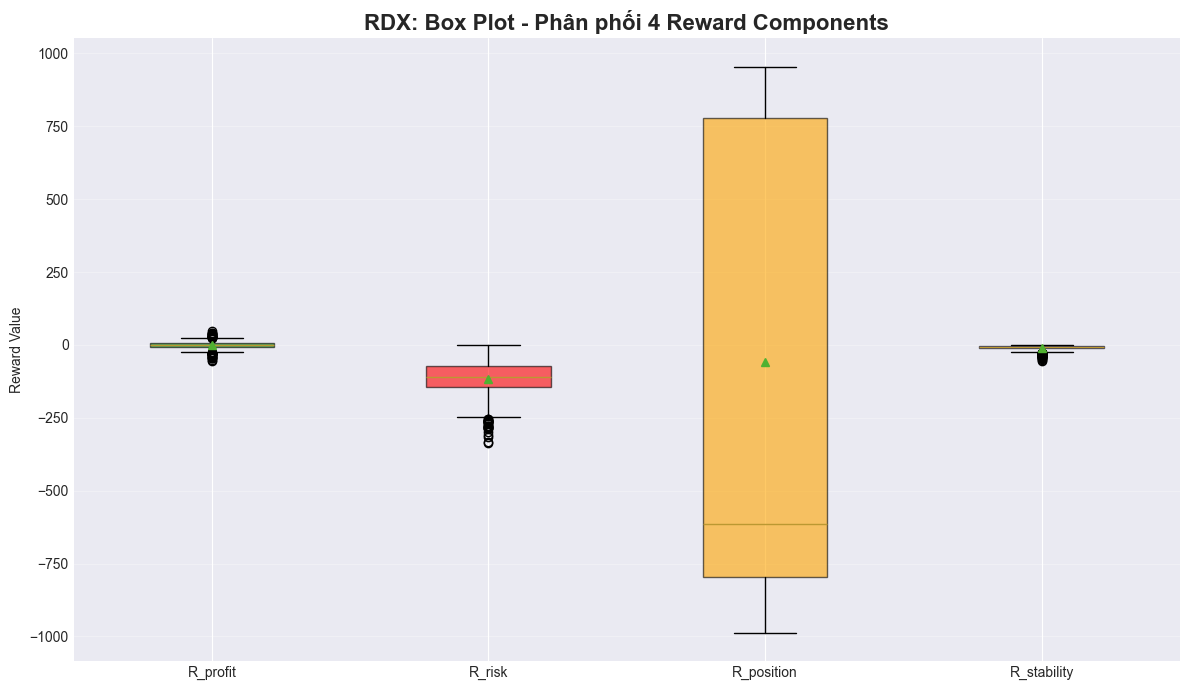

In [ ]:
# Weighted contributions của từng component với RDX weights
contrib_profit = w_rdx[0] * R_profit
contrib_risk = w_rdx[1] * R_risk
contrib_position = w_rdx[2] * R_position
contrib_stability = w_rdx[3] * R_stability

# Stacked Area Chart và Timeline
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Subplot 1: Stacked area chart
x = np.arange(len(contrib_profit))
axes[0].fill_between(x, 0, contrib_profit, label='Profit', alpha=0.7, color='green')
axes[0].fill_between(x, contrib_profit, contrib_profit + contrib_risk, 
                     label='Risk', alpha=0.7, color='red')
axes[0].fill_between(x, contrib_profit + contrib_risk, 
                     contrib_profit + contrib_risk + contrib_position,
                     label='Position', alpha=0.7, color='orange')
axes[0].fill_between(x, contrib_profit + contrib_risk + contrib_position,
                     R_reconstructed, label='Stability', alpha=0.7, color='blue')
# axes[0].plot(R_original, 'k--', linewidth=2, alpha=0.6, label='R_original')
axes[0].set_title('RDX: Stacked Reward Components Timeline (Weighted)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Reward Contribution')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Individual components over time
axes[1].plot(R_profit, label='R_profit (raw)', alpha=0.7, linewidth=1.5, color='green')
axes[1].plot(R_risk, label='R_risk (raw)', alpha=0.7, linewidth=1.5, color='red')
axes[1].plot(R_position, label='R_position (raw)', alpha=0.7, linewidth=1.5, color='orange')
axes[1].plot(R_stability, label='R_stability (raw)', alpha=0.7, linewidth=1.5, color='blue')
axes[1].set_title('RDX: Raw Reward Components Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Reward Value (unweighted)')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# Subplot 3: Weighted contributions
axes[2].plot(contrib_profit, label=f'Profit (w={w_rdx[0]:.1f})', linewidth=2, alpha=0.8, color='green')
axes[2].plot(contrib_risk, label=f'Risk (w={w_rdx[1]:.1f})', linewidth=2, alpha=0.8, color='red')
axes[2].plot(contrib_position, label=f'Position (w={w_rdx[2]:.1f})', linewidth=2, alpha=0.8, color='orange')
axes[2].plot(contrib_stability, label=f'Stability (w={w_rdx[3]:.1f})', linewidth=2, alpha=0.8, color='blue')
axes[2].set_title('RDX: Weighted Contributions Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Weighted Contribution')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# # Box plot - Phân phối
# fig, ax = plt.subplots(figsize=(12, 7))
# data_to_plot = [R_profit, R_risk, R_position, R_stability]
# bp = ax.boxplot(data_to_plot, labels=['R_profit', 'R_risk', 'R_position', 'R_stability'],
#                 patch_artist=True, showmeans=True)

# colors = ['green', 'red', 'orange', 'blue']
# for patch, color in zip(bp['boxes'], colors):
#     patch.set_facecolor(color)
#     patch.set_alpha(0.6)

# ax.set_title('RDX: Box Plot - Phân phối 4 Reward Components', fontsize=16, fontweight='bold')
# ax.set_ylabel('Reward Value')
# ax.grid(True, axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()